<a href="https://colab.research.google.com/github/GonzaloHirsch/sia-tps/blob/master/Fashion_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación por Autoencoders

Este ejemplo buenísimo muestra como se puede usar la información del espacio latente de los autoencoders para interpolar nuevos ejemplos de los dígitos de códigos postales de MNIST.

Está sacado del libro de Langr, "GANs in action"

Este código de adaptó a partir del código original de **Rodrigo Ramele**

In [16]:

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
import tensorflow as tf

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
### end of hack

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist as mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()



print(np.__version__)



1.19.5


In [17]:

# defining the key parameters
batch_size = 100

# Parameters of the input images
original_dim = 28*28

# Latent space is of dimension 2.  This means that we are reducing the dimension from 784 to 2
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

La función de Sampling es la que toma la salida de la media y la varianza que estima el Encoder y la usa para generar una muestra que va a servir a estimar la pdf de los datos.

In [18]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon  # h(z)

# Codificador

Esta primera parte define el codificador, es decir la primera red que baja la dimensionalidad de los datos.

In [19]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

# Decodificador

Esta segunda parte es la definición del decodificador, que es la segunda parte que decodifica la información del espacio latente hacia la salida final de las dos redes en serie.

In [20]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


# Autoencoder completo

Se combinan las dos partes.  Primero el Codificador y luego del decodifcador.  Acá se muestra la información de cómo queda el modelo.

In [21]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


# Función de perdida

Se define la función de perdida, y se establece cuál va a ser la función de optimización.

In [22]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  # Aca se computa la cross entropy entre los "labels" x que son los valores 0/1 de los pixeles, y lo que salió al final del Decoder.
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # x-^X
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile( loss=vae_loss,experimental_run_tf_function=False)
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


Se cargan los datos de la base de datos de MNIST

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Se entrena finalmente la red de forma completa.

In [24]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)


Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 152us/sample - loss: 306.1371
Epoch 2/50
60000/60000 [==============================] - 9s 147us/sample - loss: 277.9819
Epoch 3/50
60000/60000 [==============================] - 9s 147us/sample - loss: 273.5898
Epoch 4/50
60000/60000 [==============================] - 9s 144us/sample - loss: 271.8096
Epoch 5/50
60000/60000 [==============================] - 9s 145us/sample - loss: 270.6123
Epoch 6/50
60000/60000 [==============================] - 9s 148us/sample - loss: 269.6248
Epoch 7/50
60000/60000 [==============================] - 9s 148us/sample - loss: 268.8091
Epoch 8/50
60000/60000 [==============================] - 9s 148us/sample - loss: 268.1521
Epoch 9/50
60000/60000 [==============================] - 9s 147us/sample - loss: 267.5439
Epoch 10/50
60000/60000 [==============================] - 9s 147us/sample - loss: 267.0069
Epoch 11/50
60000/60000 [==============================] - 9s 148u

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


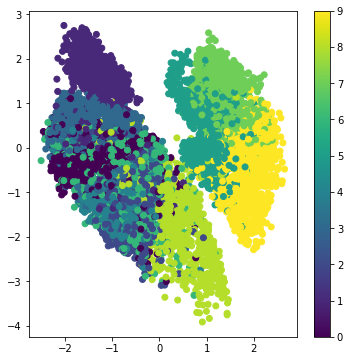

In [25]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

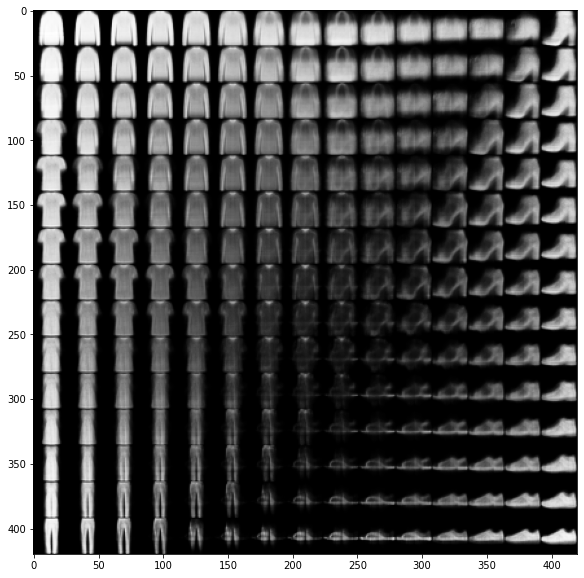

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44]
 [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74]
 [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]
 [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
 [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]
 [195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224]]
0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
21

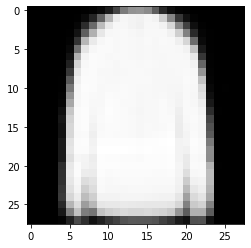

In [27]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

zpoints = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        zpoints.append(z_sample)
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

figure = np.zeros((digit_size, digit_size))

def spiral(X, Y):
    x = y = 0
    dx, dy = 1, 1
    xr, xl = X, 0
    yt, yb = Y, 1
    xmove = True
    points = []
    count = 0
    while count < (X*Y)-1:
      if xmove:
        xnext = x + dx
        if xnext < xl or xnext >= xr:
          if dx > 0:
            xr -= 1
          else:
            xl += 1
          dx *= -1
          xmove = False
        else:
          points.append([x,y])
          x += dx
          count += 1
      else:
        ynext = y + dy
        if ynext < yb or ynext >= yt:
          if dy > 0:
            yt -= 1
          else:
            yb += 1
          dy *= -1
          xmove = True
        else:
          points.append([x,y])
          y += dy
          count += 1
    points.append([int(X/2), int(Y/2)])
    return points


points = spiral(n,n)

dat = np.array(range(0, n*n)).reshape((n,n))

# Animation
fig, ax = plt.subplots()
ln = plt.imshow(figure, cmap='Greys_r', animated=True)
frame = 0
def update(frame):
    print('Frame', frame)
    z = dat[points[frame][0], points[frame][1]]
    figure = decoder.predict(zpoints[z])[0].reshape(digit_size, digit_size)
    ln.set_array(figure)
    plt.imshow(figure, cmap='Greys_r')
    frame += 1
    return [ln]

ani = FuncAnimation(fig, update, frames=n*n, interval=75)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
plt.show()